In [1]:
#MODIFIED large_scale_unlearning.ipynb from https://github.com/meghdadk/SCRUB/blob/main/large_scale_unlearning.ipynb

In [1]:
#%load_ext autoreload
#%autoreload 2
#%matplotlib inline
import os
import time
import math
import pandas as pd
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
    
import numpy as np
import random 
import copy
import torch
import torch.nn as nn
from typing import List
import itertools
#from tqdm.autonotebook import tqdm
from tqdm import tqdm

import pickle

In [2]:
import models
import datasets

In [3]:
#from models import *
#import models
#from logger import *

from SCRUB.helper.util import adjust_learning_rate as sgda_adjust_learning_rate
from SCRUB.distiller_zoo.KD import DistillKL

from SCRUB.helper.loops import train_distill, train_vanilla, validate
from SCRUB.helper.pretrain import init
from SCRUB.helper.util import AverageMeter

In [4]:
### Activations along the path
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return TP, FP, TN, FN

def entropy(p, dim = -1, keepdim = False):
    return -torch.where(p > 0, p * p.log(), p.new([0.0])).sum(dim=dim, keepdim=keepdim)
    #return (p * p.log()).sum(dim=dim, keepdim=keepdim)

def collect_prob(data_loader, model):
    data_loader = torch.utils.data.DataLoader(data_loader.dataset, batch_size=1, shuffle=False)
    sampler = torch.utils.data.RandomSampler(data_loader.dataset, replacement=False, num_samples=4000)
    data_loader_small = torch.utils.data.DataLoader(data_loader.dataset, batch_size=1, sampler=sampler, shuffle=False)
    prob = []
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(data_loader_small, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            data, target = batch
            output = model(data)
            prob.append(F.softmax(output, dim=-1).data)
    return torch.cat(prob)

def get_membership_attack_data(retain_loader, forget_loader, test_loader, model):    
    retain_prob = collect_prob(retain_loader, model)
    forget_prob = collect_prob(forget_loader, model)
    test_prob = collect_prob(test_loader, model)
    
    X_r = torch.cat([entropy(retain_prob), entropy(test_prob)]).cpu().numpy().reshape(-1, 1)
    Y_r = np.concatenate([np.ones(len(retain_prob)), np.zeros(len(test_prob))])
    
    X_f = entropy(forget_prob).cpu().numpy().reshape(-1, 1)
    Y_f = np.concatenate([np.ones(len(forget_prob))])    
    return X_f, Y_f, X_r, Y_r

def get_membership_attack_prob(retain_loader, forget_loader, test_loader, model):
    X_f, Y_f, X_r, Y_r = get_membership_attack_data(retain_loader, forget_loader, test_loader, model)
    #clf = SVC(C=3,gamma='auto',kernel='rbf')
    clf = LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='multinomial')
    clf.fit(X_r, Y_r)
    results = clf.predict(X_f)
    results1 = clf.predict(X_r)
    acc = accuracy_score(results, Y_f)
    train_ac = accuracy_score(results1, Y_r)
    TP, FP, TN, FN = perf_measure(Y_r, results1)
    FPR = FP/(FP+TN)
    FNR = FN/(FN+TP)
    
    print (f"TP:{TP}, FP{FP}, TN{TN}, FN{FN}")
    print (f"false negative rate: {FN/(FN+TP)}")
    print (f"false positive rate: {FP/(FP+TN)}")
    return acc, train_acc, FPR, FNR #results.mean(), results1.mean()
    
def plot_entropy_dist(model,retain_loader,forget_loader,test_loader_full, title, ax):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.ticker import FuncFormatter
    #train_loader_full, valid_loader_full, test_loader_full = datasets.get_loaders(dataset, batch_size=100, seed=0, augment=False, shuffle=False)
    #indexes = np.flatnonzero(np.array(train_loader_full.dataset.targets) == class_to_forget)
    #replaced = np.random.RandomState(0).choice(indexes, size=100 if num_to_forget==100 else len(indexes), replace=False)
    X_f, Y_f, X_r, Y_r = get_membership_attack_data(retain_loader,forget_loader,test_loader_full, model)
    #np.savetxt('retain_prob.txt', X_r[Y_r==1])
    #np.savetxt('forget_prob.txt', X_f)
    #np.savetxt('test_prob.txt', X_r[Y_r==0])
    sns.distplot(np.log(X_r[Y_r==1]).reshape(-1), kde=False, norm_hist=True, rug=False, label='retain', ax=plt)
    sns.distplot(np.log(X_r[Y_r==0]).reshape(-1), kde=False, norm_hist=True, rug=False, label='test', ax=plt)
    sns.distplot(np.log(X_f).reshape(-1), kde=False, norm_hist=True, rug=False, label='forget', ax=plt)
    plt.legend(prop={'size': 14})
    plt.tick_params(labelsize=12)
    plt.title(title,size=18)
    plt.xlabel('Log of Entropy',size=14)
    plt.show()
    plt.clf()


def membership_attack(retain_loader,forget_loader,test_loader,model, name):
    prob, train_acc, FPR, FNR = get_membership_attack_prob(retain_loader,forget_loader,test_loader,model)
    print("Attack prob: ", prob)
    return prob

In [5]:
#from utils import *
def get_metrics(model,dataloader,criterion,device, samples_correctness=False,use_bn=False,delta_w=None,scrub_act=False):
    activations=[]
    predictions=[]
    if use_bn:
        model.train()
        dataloader = torch.utils.data.DataLoader(retain_loader.dataset, batch_size=128, shuffle=True)
        for i in range(10):
            for batch_idx, (data, target, _) in enumerate(dataloader):
                data, target = data.to(device), target.to(device)            
                output = model(data)
    dataloader = torch.utils.data.DataLoader(dataloader.dataset, batch_size=1, shuffle=False)
    model.eval()
    metrics = AverageMeter()
    mult = 0.5 if args.lossfn=='mse' else 1
    for batch_idx, (data, target, _) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)            
        if args.lossfn=='mse':
            target=(2*target-1)
            target = target.type(torch.cuda.FloatTensor).unsqueeze(1)
        output = model(data)
        if scrub_act:
            G = []
            for cls in range(num_classes):
                grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                grads = torch.cat([g.view(-1) for g in grads])
                G.append(grads)
            grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
            G = torch.stack(G).pow(2)
            delta_f = torch.matmul(G,delta_w)
            output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()

        loss = mult*criterion(output, target)
        if samples_correctness:
            activations.append(torch.nn.functional.softmax(output,dim=1).cpu().detach().numpy().squeeze())
            predictions.append(get_error(output,target))
        metrics.update(n=data.size(0), loss=loss.item(), error=get_error(output, target))
    if samples_correctness:
        return metrics.avg,np.stack(activations),np.array(predictions)
    else:
        return metrics.avg

In [6]:
def activations_predictions(model,dataloader,name): #WTF IS THIS
    criterion = torch.nn.CrossEntropyLoss()
    metrics=get_metrics(model,dataloader,criterion, device, False)
    print(f"{name} -> Loss:{np.round(metrics['loss'],3)}, Error:{metrics['error']}")
    log_dict[f"{name}_loss"]=metrics['loss']
    log_dict[f"{name}_error"]=metrics['error']
    return _,_

In [7]:
def predictions_distance(l1,l2,name):
    dist = np.sum(np.abs(l1-l2))
    print(f"Predictions Distance {name} -> {dist}")
    log_dict[f"{name}_predictions"]=dist

In [8]:
def activations_distance(a1,a2,name):
    dist = np.linalg.norm(a1-a2,ord=1,axis=1).mean()
    print(f"Activations Distance {name} -> {dist}")
    log_dict[f"{name}_activations"]=dist

In [9]:
def l2_penalty(model,model_init,weight_decay):
    l2_loss = 0
    for (k,p),(k_init,p_init) in zip(model.named_parameters(),model_init.named_parameters()):
        if p.requires_grad:
            l2_loss += (p-p_init).pow(2).sum()
    l2_loss *= (weight_decay/2.)
    return l2_loss

def run_train_epoch(model: nn.Module, model_init, data_loader: torch.utils.data.DataLoader, 
                    loss_fn: nn.Module,
                    optimizer: torch.optim.SGD, split: str, epoch: int, ignore_index=None,
                    negative_gradient=False, negative_multiplier=-1, random_labels=False,
                    quiet=False,delta_w=None,scrub_act=False):
    model.eval()
    metrics = AverageMeter()    
    num_labels = data_loader.dataset.targets.max().item() + 1
    
    with torch.set_grad_enabled(split != 'test'):
        for idx, batch in enumerate(tqdm(data_loader, leave=False)):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            input, target = batch
            output = model(input)
            if split=='test' and scrub_act:
                G = []
                for cls in range(num_classes):
                    grads = torch.autograd.grad(output[0,cls],model.parameters(),retain_graph=True)
                    grads = torch.cat([g.view(-1) for g in grads])
                    G.append(grads)
                grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
                G = torch.stack(G).pow(2)
                delta_f = torch.matmul(G,delta_w)
                output += delta_f.sqrt()*torch.empty_like(delta_f).normal_()
            loss = loss_fn(output, target) + l2_penalty(model,model_init,args.weight_decay)
            metrics.update(n=input.size(0), loss=loss_fn(output,target).item(), error=get_error(output, target))
            
            if split != 'test':
                model.zero_grad()
                loss.backward()
                optimizer.step()
    if not quiet:
        log_metrics(split, metrics, epoch)
    return metrics.avg

In [10]:
def finetune(model: nn.Module, data_loader: torch.utils.data.DataLoader, lr=0.01, epochs=10, quiet=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0)
    model_init=copy.deepcopy(model)
    for epoch in range(epochs):
        #run_train_epoch(model, model_init, data_loader, loss_fn, optimizer, split='train', epoch=epoch, ignore_index=None, quiet=quiet)
        train_vanilla(epoch, data_loader, model, loss_fn, optimizer, args)

def test(model, data_loader):
    loss_fn = nn.CrossEntropyLoss()
    model_init=copy.deepcopy(model)
    return run_train_epoch(model, model_init, data_loader, loss_fn, optimizer=None, split='test', epoch=epoch, ignore_index=None, quiet=True)

In [11]:
def test_activations(model_scrubf, modelf0, delta_w_s, delta_w_m0, data_loader, \
                    loss_fn=nn.CrossEntropyLoss(),\
                    optimizer=torch.optim.SGD, \
                    seed=1,quiet=False):

    model_scrubf.eval()
    modelf0.eval()
    
    data_loader = torch.utils.data.DataLoader(data_loader.dataset, batch_size=1, shuffle=False)

    
    metrics = AverageMeter()    
    num_classes = data_loader.dataset.targets.max().item() + 1
    
    for idx, batch in enumerate(tqdm(data_loader, leave=False)):
        batch = [tensor.to(next(model_scrubf.parameters()).device) for tensor in batch]
        input, target = batch
        
        output_sf = model_scrubf(input)
        G_sf = []

        for cls in range(num_classes):
            grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=True)
            grads = torch.cat([g.view(-1) for g in grads])
            G_sf.append(grads)

        grads = torch.autograd.grad(output_sf[0,cls],model_scrubf.parameters(),retain_graph=False)
            
        G_sf = torch.stack(G_sf)#.pow(2)
        delta_f_sf_update = torch.matmul(G_sf,delta_w_s.sqrt()*torch.empty_like(delta_w_s).normal_())
        G_sf = G_sf.pow(2)
        delta_f_sf = torch.matmul(G_sf,delta_w_s)

        output_m0 = modelf0(input)
        G_m0 = []

        for cls in range(num_classes):
            grads = torch.autograd.grad(output_m0[0,cls],modelf0.parameters(),retain_graph=True)
            grad_m0 = torch.cat([g.view(-1) for g in grads])
            G_m0.append(grad_m0)

        grads = torch.autograd.grad(output_m0[0,cls],modelf0.parameters(),retain_graph=False)
            
        G_m0 = torch.stack(G_m0).pow(2)
        delta_f_m0 = torch.matmul(G_m0,delta_w_m0)
        
        kl = ((output_m0 - output_sf).pow(2)/delta_f_m0 + delta_f_sf/delta_f_m0 - torch.log(delta_f_sf/delta_f_m0) - 1).sum()
        
        torch.manual_seed(seed)
        output_sf += delta_f_sf_update#delta_f_sf.sqrt()*torch.empty_like(delta_f_sf).normal_()
        
        loss = loss_fn(output_sf, target)
        metrics.update(n=input.size(0), loss=loss.item(), error=get_error(output_sf, target), kl=kl.item())
    
    return metrics.avg

### Pre-training

In [12]:
#%run main.py --dataset cifar100 --dataroot=data/cifar-100-python --model resnet --filters 1.0 --lr 0.1 --lossfn ce --num-classes 100

### Train the original model

In [13]:
#%run main_merged.py --dataset cifar10 --model allcnn --dataroot=data/cifar-10-batches-py/ --filters 1.0 --lr 0.01 \
#--resume checkpoints/cifar100_allcnn_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_30.pt --disable-bn \
#--weight-decay 5e-4 --batch-size 128 --epochs 26 --seed 1

### Retrain Forgetting

In [14]:
# %run main_merged.py --dataset cifar10 --model allcnn --dataroot=data/cifar-10-batches-py/ --filters 1 --lr 0.01 \
# --resume checkpoints/cifar100_allcnn_1_0_forget_None_lr_0_1_bs_128_ls_ce_wd_0_0005_seed_1_30.pt --disable-bn \
# --weight-decay 5e-4 --batch-size 128 --epochs 26 \
# --forget-class 5 --seed 1

#### Logs

In [15]:
log_dict={}

### Load model

In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model = models.get_model('mlp', num_classes=2, filters_percentage=1)
model.to(device)
dataroot = 'data/eicu/'

In [17]:

seed = 1
checkpoint_name = 'eicu_mlp_1_0_forget_None_lr_0_01_bs_2048_ls_ce_seed_1_scheduler_1'


with open(f'logs/{checkpoint_name}.pkl', 'rb') as f:
    train_dict = pickle.load(f)

eta = 0.01
n = 94449

G = max(train_dict['grad norm over epochs'])
batch_size = train_dict['batch_size']
Nepochs = train_dict['selected epoch']+1
Nbatches = math.ceil(n/batch_size)
L = train_dict['Lipschitz']


#eps = 10000000
T = Nepochs * Nbatches

delta = 0.1

og_name = f'eicu_mlp_1_0_forget_None_lr_0_01_bs_2048_ls_ce_seed_{seed}_scheduler_1_selected'
full_retrain_name = f'eicu_mlp_1_0_forget_940_lr_0_01_bs_2048_ls_ce_seed_{seed}_scheduler_1_loadedfrominit_{Nepochs - 0 - 1}_final'

In [18]:
seed = 1
loaders = datasets.get_loaders_large('eicu', num_ids_forget = 940, batch_size=2048, seed=seed, root=dataroot, augment=False, ood=False, test=True)

train_loader = loaders['train_loader']
train_forget_loader = loaders['train_forget_loader']
forget_loader = loaders['forget_loader']

test_loader = loaders['test_loader']
test_forget_loader = loaders['test_forget_loader']
test_retain_loader = loaders['test_retain_loader']

m = n - len(train_loader.dataset)

#ood_dataset = copy.deepcopy(test_loader.dataset)
#ood_dataset.indices = np.array(new_indices)
#class_balance = sum(train_forget_loader.dataset.targets[train_forget_loader.dataset.indices])/len(train_forget_loader.dataset) #og class balance
#balance_classes(ood_dataset, class_balance)
#ood_loader = torch.utils.data.DataLoader(ood_dataset, batch_size=256, shuffle=True) #shuffle


Forgetting these IDs: ['009-8135' '029-2185' '002-11270' '022-101536' '027-81884' '029-6088'
 '003-18285' '027-109343' '002-21943' '002-54302' '017-64734' '018-49082'
 '022-19934' '006-48721' '009-2173' '025-10338' '035-6783' '021-190306'
 '033-25315' '002-26718' '009-487' '017-86639' '033-15944' '029-23003'
 '004-9204' '030-43409' '021-211935' '002-48177' '006-200978' '011-48327'
 '016-19537' '022-158731' '035-11739' '002-44660' '025-32034' '015-46653'
 '022-152359' '021-94606' '004-64374' '021-74836' '022-47800' '017-74617'
 '007-986' '017-76322' '016-24216' '027-167200' '009-3185' '013-38740'
 '016-28038' '018-113728' '005-30409' '030-15977' '002-63997' '027-177194'
 '035-17663' '025-49078' '021-75597' '004-8513' '017-11016' '022-27974'
 '013-14708' '015-95633' '002-62839' '006-159640' '021-62678' '007-10214'
 '002-24476' '007-406' '025-1022' '017-82508' '031-20621' '002-48718'
 '033-33384' '018-84398' '013-38101' '027-36469' '002-301' '022-77313'
 '022-185192' '027-154143' '013-151

In [19]:
retain_loader = train_forget_loader
valid_loader = loaders['valid_loader'] 

### Loads checkpoints

In [20]:
import copy
model0 = copy.deepcopy(model)

m_name = og_name #f'checkpoints/{dataset}_{arch_filters}_forget_None{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'
m0_name = full_retrain_name#f'checkpoints/{dataset}_{arch_filters}_forget_{class_to_forget}{num_tag}{unfreeze_tag}{augment_tag}{learningrate}{batch_size}{lossfn}{wd}{seed_name}{training_epochs}.pt'

model.load_state_dict(torch.load('checkpoints/' + m_name + '.pt', weights_only='True'))
model0.load_state_dict(torch.load('checkpoints/' + m0_name + '.pt', weights_only='True'))


model.cuda()
model0.cuda()


for p in model.parameters(): #what is the point of this
    p.data0 = p.data.clone()
for p in model0.parameters():
    p.data0 = p.data.clone()

teacher = copy.deepcopy(model)
student = copy.deepcopy(model)

## SCRUB Forgetting

In [22]:
from argparse import Namespace

# start with an empty Namespace
args = Namespace()

In [23]:
#large-scale hyperparameters
args.optim = 'sgd'
args.gamma = 0.99
args.alpha = 0.001
args.beta = 0
args.smoothing = 0.0
args.msteps = 2
args.clip = 0.2
args.sstart = 10
args.kd_T = 4
args.distill = 'kd'

args.sgda_batch_size = 128
args.del_batch_size = 32
args.sgda_epochs = 3
args.sgda_epochs = 10
args.sgda_learning_rate = 0.0005
#args.lr_decay_epochs = [3,5,9]
#args.lr_decay_rate = 0.1
args.sgda_weight_decay = 5e-4
args.sgda_momentum = 0.9


#small-scale hyperparameters
# args.optim = 'adam'
# args.gamma = 1
# args.alpha = 0.5
# args.beta = 0
# args.smoothing = 0.5
# args.msteps = 3
# args.clip = 0.2
# args.sstart = 10
# args.kd_T = 2
# args.distill = 'kd'

# args.sgda_epochs = 10
# args.sgda_learning_rate = 0.0005
# args.lr_decay_epochs = [5,8,9]
# args.lr_decay_rate = 0.1
# args.sgda_weight_decay = 0.1#5e-4
# args.sgda_momentum = 0.9


args.lossfn = 'ce'

In [24]:
model_t = copy.deepcopy(teacher)
model_s = copy.deepcopy(student)

In [25]:
module_list = nn.ModuleList([])
module_list.append(model_s)
trainable_list = nn.ModuleList([])
trainable_list.append(model_s)

criterion_cls = nn.CrossEntropyLoss()
criterion_div = DistillKL(args.kd_T)
criterion_kd = DistillKL(args.kd_T)


criterion_list = nn.ModuleList([])
criterion_list.append(criterion_cls)    # classification loss
criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
criterion_list.append(criterion_kd)     # other knowledge distillation loss

# optimizer
if args.optim == "sgd":
    optimizer = torch.optim.SGD(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          momentum=args.sgda_momentum,
                          weight_decay=args.sgda_weight_decay)
elif args.optim == "adam": 
    optimizer = torch.optim.Adam(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          weight_decay=args.sgda_weight_decay)
elif args.optim == "rmsp":
    optimizer = torch.optim.RMSprop(trainable_list.parameters(),
                          lr=args.sgda_learning_rate,
                          momentum=args.sgda_momentum,
                          weight_decay=args.sgda_weight_decay)

In [26]:
module_list.append(model_t)

if torch.cuda.is_available():
    module_list.cuda()
    criterion_list.cuda()
    import torch.backends.cudnn as cudnn
    cudnn.benchmark = True

In [28]:
acc_rs = []
acc_fs = []
acc_ts = []
acc_vs = []
for epoch in range(1, args.sgda_epochs + 1):

    lr = sgda_adjust_learning_rate(epoch, args, optimizer)

    print("==> SCRUB unlearning ...")

    acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
    acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
    acc_v, acc5_v, loss_v = validate(valid_loader, model_s, criterion_cls, args, True)
    acc_rs.append(100-acc_r.item())
    acc_fs.append(100-acc_f.item())
    acc_vs.append(100-acc_v.item())

    maximize_loss = 0
    if epoch <= args.msteps:
        maximize_loss = train_distill(epoch, forget_loader, module_list, None, criterion_list, optimizer, args, "maximize")
    train_acc, train_loss = train_distill(epoch, retain_loader, module_list, None, criterion_list, optimizer, args, "minimize")

    
    print ("maximize loss: {:.10f}\t minimize loss: {:.2f}\t train_acc: {}".format(maximize_loss, train_loss, train_acc))
acc_r, acc5_r, loss_r = validate(retain_loader, model_s, criterion_cls, args, True)
acc_f, acc5_f, loss_f = validate(forget_loader, model_s, criterion_cls, args, True)
acc_v, acc5_v, loss_v = validate(valid_loader, model_s, criterion_cls, args, True)
acc_rs.append(100-acc_r.item())
acc_fs.append(100-acc_f.item())
acc_vs.append(100-acc_v.item())

==> SCRUB unlearning ...
 * Acc@1 68.860 
maximize loss: -0.0000064061	 minimize loss: 0.57	 train_acc: 68.86005401611328
==> SCRUB unlearning ...
 * Acc@1 68.860 
maximize loss: -0.0000064430	 minimize loss: 0.57	 train_acc: 68.86005401611328
==> SCRUB unlearning ...
 * Acc@1 68.860 
maximize loss: 0.0000000000	 minimize loss: 0.57	 train_acc: 68.86005401611328
==> SCRUB unlearning ...
 * Acc@1 68.860 
maximize loss: 0.0000000000	 minimize loss: 0.57	 train_acc: 68.86005401611328
==> SCRUB unlearning ...
 * Acc@1 68.860 
maximize loss: 0.0000000000	 minimize loss: 0.57	 train_acc: 68.86005401611328
==> SCRUB unlearning ...
 * Acc@1 68.953 
maximize loss: 0.0000000000	 minimize loss: 0.57	 train_acc: 68.9527359008789
==> SCRUB unlearning ...
 * Acc@1 68.953 
maximize loss: 0.0000000000	 minimize loss: 0.57	 train_acc: 68.9527359008789
==> SCRUB unlearning ...
 * Acc@1 68.953 
maximize loss: 0.0000000000	 minimize loss: 0.57	 train_acc: 68.9527359008789
==> SCRUB unlearning ...
 * Acc@1

In [29]:
model_s

MLP(
  (l1): Linear(in_features=467, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=64, bias=True)
  (l5): Linear(in_features=64, out_features=2, bias=True)
)

In [38]:
 torch.save(model_s.state_dict(), f"other_baselines/SCRUB_{checkpoint_name}.pt") 

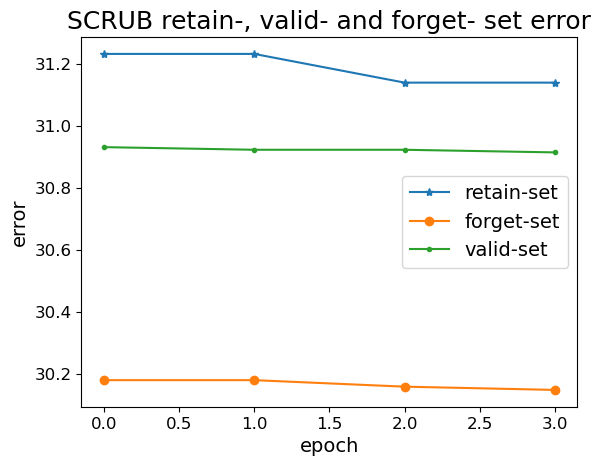

In [29]:
from matplotlib import pyplot as plt
indices = list(range(0,len(acc_rs)))
plt.plot(indices, acc_rs, marker='*', alpha=1, label='retain-set')
plt.plot(indices, acc_fs, marker='o', alpha=1, label='forget-set')
plt.plot(indices, acc_vs, marker='.', alpha=1, label='valid-set')
plt.legend(prop={'size': 14})
plt.tick_params(labelsize=12)
plt.title('SCRUB retain-, valid- and forget- set error',size=18)
plt.xlabel('epoch',size=14)
plt.ylabel('error',size=14)
plt.show()

In [30]:
#OOD

def balance_classes(dataset, desired_balance, seed = None): #I think this only works if desired_balance < 0.5 

    if seed is not None:
        random.seed(seed)
        
    labels = dataset.targets[dataset.indices]

    new_indices = []

    large_number_indices = []

    n = len(labels)
    num_ones = sum(labels)
    current_balance = num_ones/n

    print(current_balance)

    if current_balance < desired_balance:
        m = current_balance*n/desired_balance
        for i in range(len(dataset.indices)):
            if labels[i] == 1:
                new_indices.append(dataset.indices[i])
            elif labels[i] == 0:
                large_number_indices.append(dataset.indices[i])
        subset_zeros = random.sample(large_number_indices, int((1 - desired_balance)*m))
        final_indices = new_indices + list(subset_zeros)
    else:
        m = (1 - current_balance)*n/(1 - desired_balance)
        for i in range(len(dataset.indices)):
            if labels[i] == 1:
                large_number_indices.append(dataset.indices[i])
            elif labels[i] == 0:
                new_indices.append(dataset.indices[i])
        subset_ones = random.sample(large_number_indices, int(desired_balance*m))
        final_indices = new_indices + list(subset_ones)


    
    dataset.indices = np.array(final_indices)       

    print(sum(dataset.targets[dataset.indices])/len(dataset)) 

def ood_indices():
    loaders = datasets.get_loaders_large('eicu', batch_size=256, root=dataroot, augment=False, ood=False, test=True)
    train_loader = loaders['train_loader']
    test_loader = loaders['test_loader']

    new_indices = []

    for i in test_loader.dataset.indices:
        if test_loader.dataset.identities[i] not in train_loader.dataset.identities:
            new_indices.append(i)

    del loaders
    return np.array(new_indices)

new_indices = ood_indices()

ood_dataset = copy.deepcopy(test_loader.dataset)
ood_dataset.indices = np.array(new_indices)
class_balance = sum(train_forget_loader.dataset.targets[train_forget_loader.dataset.indices])/len(train_forget_loader.dataset) #og class balance
balance_classes(ood_dataset, class_balance)
ood_loader = torch.utils.data.DataLoader(ood_dataset, batch_size=256, shuffle=True) #shuffle


Number of training samples: 94449
Number of validation samples: 23611
Number of test samples: 29516
tensor(0.3434)
tensor(0.3791)


In [31]:
from mia import *
from umia import mia_unlearning

In [44]:
og_model = models.get_model('mlp', num_classes=2, filters_percentage=1)
og_model.to(device)

og_pt = torch.load('checkpoints/' + og_name + '.pt', weights_only='True')

og_model.load_state_dict(og_pt)

acc, auc = mia_unlearning(ood_loader, train_forget_loader, og_model, modelf, device, attack_model='LR', method='l2_distance', seed=1, balance=True, crossval=True, n_samples=100)
auc

0.5076737882811753

# Fisher Forgetting

# Fisher

In [39]:
model.load_state_dict(torch.load('checkpoints/' + m_name + '.pt', weights_only='True'))

modelf = copy.deepcopy(model)
modelf0 = copy.deepcopy(model0)

for p in itertools.chain(modelf.parameters(), modelf0.parameters()):
    p.data0 = copy.deepcopy(p.data.clone())

In [40]:
def hessian(dataset, model, device):
    model.eval()
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()

    for p in model.parameters():
        p.grad_acc = 0
        p.grad2_acc = 0
    
    for data, orig_target, _ in tqdm(train_loader):
        data, orig_target = data.to(device), orig_target.to(device)
        output = model(data)
        prob = torch.nn.functional.softmax(output, dim=-1).data

        for y in range(output.shape[1]):
            target = torch.empty_like(orig_target).fill_(y)
            loss = loss_fn(output, target)
            model.zero_grad()
            loss.backward(retain_graph=True)
            for p in model.parameters():
                if p.requires_grad:
                    p.grad_acc += (orig_target == target).float() * p.grad.data
                    p.grad2_acc += prob[:, y] * p.grad.data.pow(2)
    for p in model.parameters():
        p.grad_acc /= len(train_loader)
        p.grad2_acc /= len(train_loader)

In [41]:
hessian(retain_loader.dataset, modelf, device)
#hessian(retain_loader.dataset, modelf0)

100%|██████████| 1079/1079 [00:11<00:00, 96.15it/s]


In [42]:
def get_mean_var(p, is_base_dist=False, alpha=3e-6, num_classes=2):
    var = copy.deepcopy(1./(p.grad2_acc+1e-8))
    var = var.clamp(max=1e3)
    if p.size(0) == num_classes:
        var = var.clamp(max=1e2)
    var = alpha * var
    
    if p.ndim > 1:
        var = var.mean(dim=1, keepdim=True).expand_as(p).clone()
    if not is_base_dist:
        mu = copy.deepcopy(p.data0.clone())
    else:
        mu = copy.deepcopy(p.data0.clone())
    # if p.size(0) == num_classes and num_to_forget is None:
    #     mu[class_to_forget] = 0
    #     var[class_to_forget] = 0.0001
    if p.size(0) == num_classes:
        # Last layer
        var *= 10
    elif p.ndim == 1:
        # BatchNorm
        var *= 10
#         var*=1
    return mu, var

def kl_divergence_fisher(mu0, var0, mu1, var1):
    return ((mu1 - mu0).pow(2)/var0 + var1/var0 - torch.log(var1/var0) - 1).sum()

In [43]:
alpha = 1e-6
torch.manual_seed(seed)
for i, p in enumerate(modelf.parameters()):
    mu, var = get_mean_var(p, False, alpha=alpha)
    p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()

# for i, p in enumerate(modelf0.parameters()):
#     mu, var = get_mean_var(p, False, alpha=alpha)
#     p.data = mu + var.sqrt() * torch.empty_like(p.data0).normal_()


In [37]:
 torch.save(modelf.state_dict(), f"other_baselines/Fisher_{checkpoint_name}.pt") 

# Fine Tune

In [24]:

import time

from utils import *


from main import run_epoch_simple

def run_epoch_simple(model, data_loader, device, criterion=torch.nn.CrossEntropyLoss(), optimizer=None):
    model.train()

    with torch.set_grad_enabled(True):

        for batch_idx, (data, target, identity) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)

                
            output = model(data)
            loss = criterion(output, target) 

            optimizer.zero_grad() 
            loss.backward()

            optimizer.step()    


manual_seed(seed)



#get model
model.load_state_dict(torch.load('checkpoints/' + m_name + '.pt', weights_only='True'))


optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0, weight_decay=0)


criterion = torch.nn.CrossEntropyLoss().to(device)

train_time = 0


epochs = 10

for epoch in tqdm(range(epochs)):

    t1 = time.time()

    _ = run_epoch_simple(model, train_loader, device, criterion, optimizer)

    t2 = time.time()
    train_time += np.round(t2-t1,2)




torch.save(model.state_dict(), f"other_baselines/Finetune_{checkpoint_name}.pt") 





100%|██████████| 10/10 [00:21<00:00,  2.16s/it]
